In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gdown
from typing import List
import cv2
import dlib
from tqdm import tqdm
from tensorflow.keras import layers, Sequential, Model

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

def load_video(path: str) -> List[float]: 
    cap = cv2.VideoCapture(path)
    frames = []
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if i == 0:
            face_box = detector(frame)[0]
            landmarks = predictor(frame, face_box)
            xsum, ysum = 0, 0
            for j in range(48, 68):
                x, y = landmarks.part(j).x, landmarks.part(j).y
                xsum += x
                ysum += y
                
            xc, yc = round(xsum / 20), round(ysum / 20)
            x1, x2 = xc - 50, xc + 50
            y1, y2 = yc - 25, yc + 25
             
        frames.append(frame[y1:y2, x1:x2])
    cap.release()
    frames = tf.expand_dims(frames, -1)
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [3]:
video = load_video("./data/s1/bbaf2n.mpg")
video.shape

TensorShape([75, 50, 100, 1])

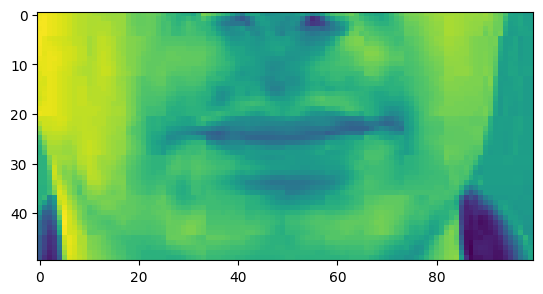

In [4]:
plt.imshow(video[0])

In [5]:
def get_transcript(file_path: str) -> str:
    words = []
    with open(file_path, "r") as f:
        for line in f.readlines():
            word = line.split()[2]
            if word != "sil":
                words.append(word)
    return " ".join(words)

In [6]:
vocab = set()
transcripts_path = "./data/alignments/s1/"

for transcript in os.listdir(transcripts_path):
    transcript_path = os.path.join(transcripts_path, transcript)
    vocab.update(get_transcript(transcript_path))
vocab = sorted(list(vocab))

In [7]:
char_to_num = layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [8]:
def load_tokens(file_path: str) -> str:
    transcript = get_transcript(file_path)
    return char_to_num(list(transcript))

In [9]:
def load_data(sample_name):
    sample_name = sample_name.numpy().decode("utf-8")
    sample_name = sample_name.split("\\")[-1]
    sample_name = sample_name.removesuffix(".mpg")
    sample_name = sample_name.removesuffix(".align")
    transcript_path = os.path.join("./data/alignments/s1", sample_name + ".align")
    video_path = os.path.join("./data/s1", sample_name + ".mpg")
    
    video = load_video(video_path)
    tokens = load_tokens(transcript_path)
    return video, tokens    

In [10]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [11]:
dataset = tf.data.Dataset.list_files("./data/s1/*.mpg")
dataset = dataset.shuffle(10)
dataset = dataset.map(mappable_function)
dataset = dataset.padded_batch(4, padded_shapes=([75, None, None, None], [40]))
dataset = dataset.prefetch(tf.data.AUTOTUNE)

train_dataset = dataset.take(int(len(dataset) * 0.8))
test_dataset = dataset.skip(int(len(dataset) * 0.8))

In [12]:
def get_lip_net():
    inputs = layers.Input([75, 50, 100, 1])
    
    conv1 = layers.Conv2D(128, 3, padding="same")(inputs)
    relu1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPool3D((1, 2, 2))(relu1)
    
    conv2 = layers.Conv2D(256, 3, padding="same")(pool1)
    relu2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPool3D((1, 2, 2))(relu2)
    
    conv3 = layers.Conv2D(75, 3, padding="same")(pool2)
    relu3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPool3D((1, 2, 2))(relu3)
    
    flat = layers.TimeDistributed(layers.Flatten())(pool3)
    
    lstm1 = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(flat)
    lstm2 = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(lstm1)
    
    outputs = layers.Dense(char_to_num.vocabulary_size() + 1, activation="softmax")(lstm2)
    
    return Model(inputs=[inputs], outputs=outputs)

In [13]:
lip_net = get_lip_net()

In [14]:
lip_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 50, 100, 1)   0         
                             ]                                   
                                                                 
 conv2d (Conv2D)             (None, 75, 50, 100, 128   1280      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 50, 100, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 25, 50, 128)   0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 25, 50, 256)   295168

In [34]:
labels = tf.convert_to_tensor([[1, 2, 0, 0]], dtype=tf.int32)
# labels = tf.one_hot(labels, 3, dtype=tf.int32)
inputs = tf.convert_to_tensor([
    [[0, 1, 0, 0],
     [0, 0, 0, 1],
     [0, 0, 1, 0]]
], dtype=tf.float32)

input_lenght = tf.constant([[3]], dtype=tf.int32)
label_length = tf.constant([[2]], dtype=tf.int32)

loss_val = tf.keras.backend.ctc_batch_cost(
    labels,
    inputs,
    input_length=input_lenght,
    label_length=label_length
)
loss_val

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[8.7288373e-07]], dtype=float32)>

In [69]:
def CTCLoss(labels, preds):
    batch_size, seq_length, _ = preds.shape
    # print(preds.shape)
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(labels, 0), tf.int32), axis=1, keepdims=True)
    input_length = tf.ones((4, 1), dtype=tf.int32) * seq_length
    
    loss_val = tf.keras.backend.ctc_batch_cost(
        labels, 
        preds,
        input_length=input_length,
        label_length=label_length
    )
    
    return loss_val

In [70]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [71]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [72]:
lip_net.compile(optimizer="adam", loss=CTCLoss)
schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
example_callback = ProduceExample(test_dataset)

In [73]:
lip_net.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


  4/200 [..............................] - ETA: 10:25 - loss: 119.6530

KeyboardInterrupt: 

In [ ]:
tf.keras.backend.ctc_batch_cost()